# Example: Modeling Based on System/Stack Ratings

This example demonstrates the use of `calc_rated_system` to test electrolyzer system configurations. Given a baseline electrolyzer definition, this tool will tune parameters such that the overall system matches a desired system rating.

For a given baseline electrolyzer stack, and desired system rating, the function implements the following procedure:

- determine a number of stacks by dividing the system rating by baseline stack rating
- tune stack parameters to achieve a stack rating that matches the desired system rating when multiplied by the number of stacks
    - modify number of cells to get close to desired stack rating
    - solve for the residual power rating by modifying cell area
    
This approach is intended to allow for smooth scaling of electrolyzer system sizes for hybrid system optimization without modifying electrolyzer configurations beyond acceptable values.


In [1]:
import pprint
import copy

import numpy as np
import matplotlib.pyplot as plt

from electrolyzer import run_electrolyzer
from electrolyzer.inputs import validation as val
from electrolyzer.glue_code.optimization import calc_rated_system

## Model Creation

In [2]:
fname_input_modeling = "./modeling_options.yaml"
modeling_options = val.load_modeling_yaml(fname_input_modeling)
pp = pprint.PrettyPrinter(indent=4)

pp.pprint(modeling_options)

{   'electrolyzer': {   'control': {   'control_type': 'BaselineDeg',
                                       'n_stacks': 1,
                                       'system_rating_MW': 2.0},
                        'costs': {},
                        'description': 'A PEM electrolyzer model',
                        'dt': 1,
                        'name': 'electrolyzer_001',
                        'stack': {   'cell_area': 1000.0,
                                     'include_degradation_penalty': True,
                                     'max_current': 2000,
                                     'n_cells': 100,
                                     'stack_rating_kW': 500,
                                     'temperature': 60}},
    'general': {'verbose': False}}


In [47]:
system_ratings = np.linspace(1.0, 500.0, 100)

In [48]:
system_ratings

array([  1.        ,   6.04040404,  11.08080808,  16.12121212,
        21.16161616,  26.2020202 ,  31.24242424,  36.28282828,
        41.32323232,  46.36363636,  51.4040404 ,  56.44444444,
        61.48484848,  66.52525253,  71.56565657,  76.60606061,
        81.64646465,  86.68686869,  91.72727273,  96.76767677,
       101.80808081, 106.84848485, 111.88888889, 116.92929293,
       121.96969697, 127.01010101, 132.05050505, 137.09090909,
       142.13131313, 147.17171717, 152.21212121, 157.25252525,
       162.29292929, 167.33333333, 172.37373737, 177.41414141,
       182.45454545, 187.49494949, 192.53535354, 197.57575758,
       202.61616162, 207.65656566, 212.6969697 , 217.73737374,
       222.77777778, 227.81818182, 232.85858586, 237.8989899 ,
       242.93939394, 247.97979798, 253.02020202, 258.06060606,
       263.1010101 , 268.14141414, 273.18181818, 278.22222222,
       283.26262626, 288.3030303 , 293.34343434, 298.38383838,
       303.42424242, 308.46464646, 313.50505051, 318.54

In [49]:
models = []

for sys_rating in system_ratings:
    options = copy.deepcopy(modeling_options)
    options["electrolyzer"]["control"]["system_rating_MW"] = sys_rating
    calc_rated_system(options)
    models.append(options)

Text(0.5, 23.52222222222222, 'System Rating (MW)')

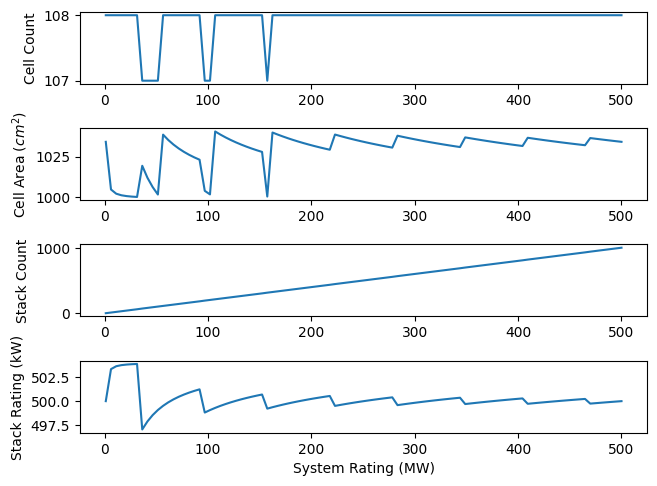

In [50]:
fig, axes = plt.subplots(4, 1)
fig.tight_layout()

n_cells = [m["electrolyzer"]["stack"]["n_cells"] for m in models]
cell_area = [m["electrolyzer"]["stack"]["cell_area"] for m in models]
stack_rating = [m["electrolyzer"]["stack"]["stack_rating_kW"] for m in models]
n_stacks = [m["electrolyzer"]["control"]["n_stacks"] for m in models]

axes[0].plot(system_ratings, n_cells)
axes[0].set_ylabel("Cell Count")

axes[1].plot(system_ratings, cell_area)
axes[1].set_ylabel("Cell Area ($cm^2$)")

axes[2].plot(system_ratings, n_stacks)
axes[2].set_ylabel("Stack Count")

axes[3].plot(system_ratings, stack_rating)
axes[3].set_ylabel("Stack Rating (kW)")
axes[3].set_xlabel("System Rating (MW)")


## Set upper and lower bounds

## Running Models for H2 Production

Run the models and compare H2 production based on test power signals. The power signals are set to match the electrolyzer system rated power for each simulation.

In [30]:
def create_power_signal(rating):
    # Create cosine test signal from rating (MW)
    test_signal_angle = np.linspace(0, 8 * np.pi, 3600 * 8 + 10)
    base_value = (rating / 2) + 0.2
    variation_value = rating - base_value
    power_test_signal = (base_value + variation_value * np.cos(test_signal_angle)) * 1e6
    
    return power_test_signal

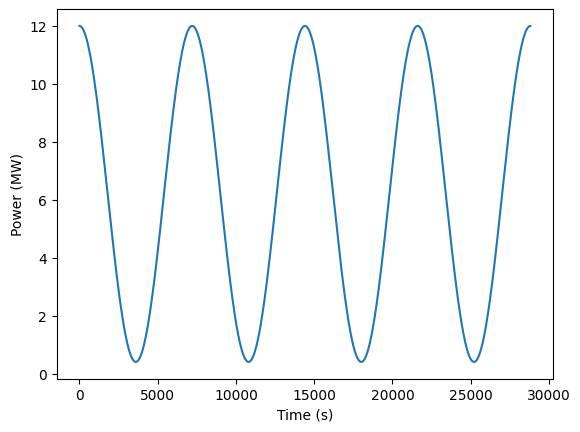

In [46]:
ax = plt.subplot(xlabel="Time (s)", ylabel="Power (MW)")

ax.plot(create_power_signal(12.0) / 1e6)

In [31]:
h2_results = []

# run 1 out of every 5 models
for m in models[::5]:
    sys_rating = m["electrolyzer"]["control"]["system_rating_MW"]
    power_test_signal = create_power_signal(sys_rating)
    _, res = run_electrolyzer(m, power_test_signal)
    h2_results.append(res)


electrolyzer stack  1 out of  2 has been initialized
electrolyzer stack  2 out of  2 has been initialized
electrolyzer stack  1 out of  3 has been initialized
electrolyzer stack  2 out of  3 has been initialized
electrolyzer stack  3 out of  3 has been initialized
electrolyzer stack  1 out of  4 has been initialized
electrolyzer stack  2 out of  4 has been initialized
electrolyzer stack  3 out of  4 has been initialized
electrolyzer stack  4 out of  4 has been initialized
electrolyzer stack  1 out of  5 has been initialized
electrolyzer stack  2 out of  5 has been initialized
electrolyzer stack  3 out of  5 has been initialized
electrolyzer stack  4 out of  5 has been initialized
electrolyzer stack  5 out of  5 has been initialized
electrolyzer stack  1 out of  6 has been initialized
electrolyzer stack  2 out of  6 has been initialized
electrolyzer stack  3 out of  6 has been initialized
electrolyzer stack  4 out of  6 has been initialized
electrolyzer stack  5 out of  6 has been initi

electrolyzer stack  1 out of  17 has been initialized
electrolyzer stack  2 out of  17 has been initialized
electrolyzer stack  3 out of  17 has been initialized
electrolyzer stack  4 out of  17 has been initialized
electrolyzer stack  5 out of  17 has been initialized
electrolyzer stack  6 out of  17 has been initialized
electrolyzer stack  7 out of  17 has been initialized
electrolyzer stack  8 out of  17 has been initialized
electrolyzer stack  9 out of  17 has been initialized
electrolyzer stack  10 out of  17 has been initialized
electrolyzer stack  11 out of  17 has been initialized
electrolyzer stack  12 out of  17 has been initialized
electrolyzer stack  13 out of  17 has been initialized
electrolyzer stack  14 out of  17 has been initialized
electrolyzer stack  15 out of  17 has been initialized
electrolyzer stack  16 out of  17 has been initialized
electrolyzer stack  17 out of  17 has been initialized
electrolyzer stack  1 out of  18 has been initialized
electrolyzer stack  

In [34]:
h2_prod = [r["kg_rate"].sum() for r in h2_results]
h2_rates = [r["kg_rate"] for r in h2_results]

Text(0, 0.5, '$H_2$ Produced (MW)')

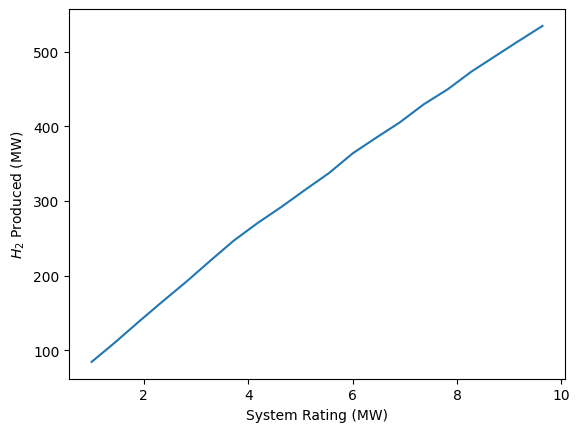

In [32]:
fig, ax = plt.subplots()

ax.plot(system_ratings[::5], h2_prod)
ax.set_xlabel("System Rating (MW)")
ax.set_ylabel("$H_2$ Produced (MW)")

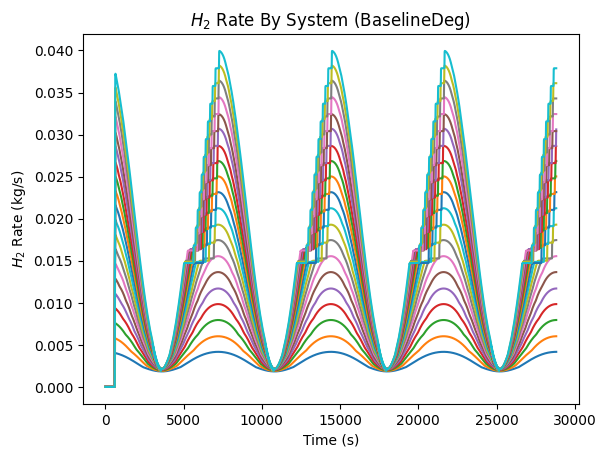

In [42]:
fig, ax = plt.subplots()
ax.set_xlabel("Time (s)")
ax.set_ylabel("$H_2$ Rate (kg/s)")
control_type = modeling_options["electrolyzer"]["control"]["control_type"]
ax.set_title(f"$H_2$ Rate By System ({control_type})")

for r in h2_rates:
    ax.plot(h2_results[0].index, r)